<a href="https://colab.research.google.com/github/ioloi1128/CDA/blob/main/CDA_week5_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install numpy
!pip install xarray
!pip install matplotlib
!pip install scipy
!pip install pandas

!apt-get install libproj-dev proj-data proj-bin
!apt-get install libgeos-dev
!pip install cython
!pip install cartopy

!apt-get -V -y -qq install python-cartopy python3-cartopy
!pip uninstall shapely -y
!pip install shapely --no-binary shapely

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libproj-dev is already the newest version (4.9.3-2).
libproj-dev set to manually installed.
proj-data is already the newest version (4.9.3-2).
proj-data set to manually installed.
The following NEW packages will be installed:
  proj-bin
0 upgraded, 1 newly installed, 0 to remove and 39 not upgraded.
Need to get 32.3 kB of archives.
After this operation, 110 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 proj-bin amd64 4.9.3-2 [32.3 kB]
Fetched 32.3 kB in 0s (77.7 kB/s)
Selecting previously unselected package proj-bin.
(Reading database ... 155335 files and directories currently installed.)
Preparing to unpack .../proj-bin_4.9.3-2_amd64.deb ...
Unpacking proj-bin (4.9.3-2) ...
Setting up proj-bin (4.9.3-2) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Reading package lists... Done
Building dependency tree       
Reading state

In [3]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats

import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker
from cartopy.util import add_cyclic_point

In [4]:
#creat a idealized case
x = np.random.normal(5.0,0.5,300) # (mean, std. deviation, N)
m = 3
b = 60
noise=np.random.normal(5,1.0,300)
y = m * x + b + noise

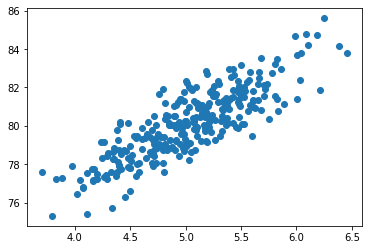

In [5]:
plt.scatter(x,y)

In [6]:
[m_fit,b_fit]=np.polyfit(x,y,1)
print(b_fit,m_fit)

65.36972336920908 2.9369251340584532


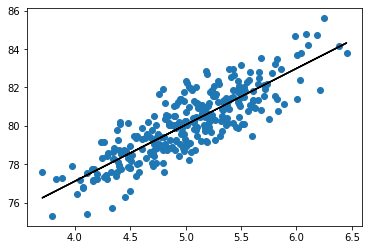

In [7]:
y_fit=m_fit*x+b_fit
plt.scatter(x,y)
plt.plot(x,y_fit,'k-')

In [8]:
#R-Squared
y_res=y_fit-y
r_squared=1-(np.var(y_res)/np.var(y))
r_squared

0.7063716991238841

In [9]:
#scipy
from scipy.stats import linregress

In [10]:
slope, intercept, r_value, p_value, std_err = linregress(x, y)

In [11]:
slope,intercept,r_value,p_value, std_err

(2.9369251340584555,
 65.36972336920908,
 0.8404592191914396,
 2.7621046046999817e-81,
 0.1096900045481534)

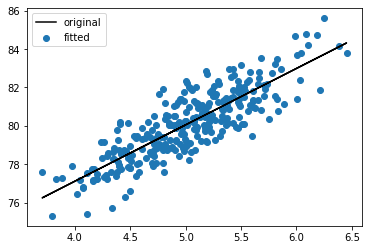

In [12]:
plt.scatter(x, y)
plt.plot(x, intercept + slope*x, 'k')
plt.legend(['original','fitted'])

In [13]:
r_sq=r_value**2
r_sq

0.7063716991238843

In [14]:
#fitting for no meaningful
y_rand=np.random.randn(len(x)) 
[m_fit_rand,b_fit_rand]=np.polyfit(x,y_rand,1)
y_fit_rand=m_fit_rand*x+b_fit_rand
print(b_fit_rand,m_fit_rand)

-0.20108902139731674 0.02390427665529761


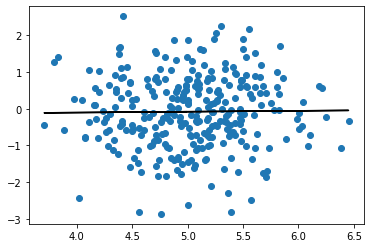

In [15]:
plt.scatter(x,y_rand)
plt.plot(x,y_fit_rand,'k-')

In [16]:
y_res_rand=y_rand-y_fit_rand
r_squared_rand=1-(np.var(y_res_rand)/np.var(y_rand))
r_squared_rand

0.00015220159948059475

The application of linear trend on climate data: Trend

In [17]:
url = 'http://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/noaa.ersst.v5/sst.mnmean.nc'
ds = xr.open_dataset(url)
#print(ds)
#ds

# select period
ds = ds.sel(time=slice('1960', '2020'))
ds

#actually load the data
ds.load()

<xarray.Dataset>
Dimensions:    (lat: 89, lon: 180, nbnds: 2, time: 732)
Coordinates:
  * lat        (lat) float32 88.0 86.0 84.0 82.0 ... -82.0 -84.0 -86.0 -88.0
  * lon        (lon) float32 0.0 2.0 4.0 6.0 8.0 ... 352.0 354.0 356.0 358.0
  * time       (time) datetime64[ns] 1960-01-01 1960-02-01 ... 2020-12-01
Dimensions without coordinates: nbnds
Data variables:
    time_bnds  (time, nbnds) float64 9.969e+36 9.969e+36 ... 9.969e+36 9.969e+36
    sst        (time, lat, lon) float32 -1.8 -1.8 -1.8 -1.8 ... nan nan nan nan
Attributes: (12/38)
    climatology:                     Climatology is based on 1971-2000 SST, X...
    description:                     In situ data: ICOADS2.5 before 2007 and ...
    keywords_vocabulary:             NASA Global Change Master Directory (GCM...
    keywords:                        Earth Science > Oceans > Ocean Temperatu...
    instrument:                      Conventional thermometers
    source_comment:                  SSTs were observed by conventional therm...
    ...                              ...
    license:                         No constraints on data access or use
    comment:                         SSTs were observed by conventional therm...
    summary:                         ERSST.v5 is developed based on v4 after ...
    dataset_title:                   NOAA Extended Reconstructed SST V5
    data_modified:                   2022-03-07
    DODS_EXTRA.Unlimited_Dimension:  time

In [18]:
#make anomaly
sst_clim = ds.sst.groupby('time.month').mean(dim='time')
sst_anom = ds.sst.groupby('time.month') - sst_clim


In [19]:
#detrend
from scipy.signal import detrend
sst_anom_detrended = xr.apply_ufunc(detrend, sst_anom.fillna(0),
                                    kwargs={'axis': 0}).where(~sst_anom.isnull())

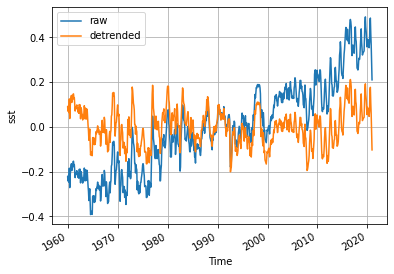

In [20]:
sst_anom.mean(dim=['lon', 'lat']).plot(label='raw')
sst_anom_detrended.mean(dim=['lon', 'lat']).plot(label='detrended')
plt.grid()
plt.legend()

In [21]:
ds_row=sst_anom.mean(dim=['lon', 'lat'])
ds_detrend=sst_anom_detrended.mean(dim=['lon', 'lat'])

xtime=sst_anom['time']
nt=len(xtime)
xts=np.arange(0, nt, 1)
ds_row

<xarray.DataArray 'sst' (time: 732)>
array([-2.24338308e-01, -2.42237985e-01, -2.16253221e-01, -2.47257397e-01,
       -1.84554592e-01, -2.71417022e-01, -2.16635257e-01, -1.94483921e-01,
       -1.74362183e-01, -1.64668098e-01, -1.94819227e-01, -1.74807280e-01,
       -1.80586159e-01, -1.56196058e-01, -1.53341323e-01, -1.70363456e-01,
       -1.68689713e-01, -1.97256431e-01, -2.26767451e-01, -2.07913786e-01,
       -2.09937915e-01, -2.03639343e-01, -1.95793718e-01, -2.14283392e-01,
       -2.10198730e-01, -2.26042375e-01, -2.06785515e-01, -2.29240254e-01,
       -1.89242691e-01, -2.11128846e-01, -1.89053148e-01, -2.50188202e-01,
       -1.99764043e-01, -2.04819500e-01, -2.23701686e-01, -2.26473629e-01,
       -2.51085252e-01, -2.38673329e-01, -2.41747767e-01, -2.19146833e-01,
       -1.83997527e-01, -2.01284572e-01, -2.41505921e-01, -1.92293376e-01,
       -2.31787443e-01, -2.39320964e-01, -1.93476245e-01, -1.98746577e-01,
       -2.33333096e-01, -2.65533566e-01, -2.87925333e-01, -3.29111487e-01,
       -3.03792626e-01, -2.76647180e-01, -3.31975847e-01, -3.91795456e-01,
       -3.80002052e-01, -3.77427012e-01, -3.90733242e-01, -3.91036838e-01,
       -3.10390085e-01, -3.08089465e-01, -3.18732440e-01, -3.07900727e-01,
       -3.37699354e-01, -3.11339468e-01, -3.34694117e-01, -3.15444231e-01,
       -2.76562512e-01, -2.84118176e-01, -2.69556403e-01, -2.64744937e-01,
       -2.46730715e-01, -2.74090230e-01, -2.58988440e-01, -2.63358861e-01,
       -2.81529188e-01, -2.76340157e-01, -2.65923500e-01, -3.31094980e-01,
...
        3.50985467e-01,  2.77762711e-01,  2.39799067e-01,  2.29892612e-01,
        2.29670763e-01,  2.16266736e-01,  2.49739677e-01,  2.88662910e-01,
        3.26346248e-01,  3.46801281e-01,  3.80195379e-01,  4.10287380e-01,
        4.44100589e-01,  4.43271160e-01,  4.06267673e-01,  3.87806177e-01,
        4.36081827e-01,  3.84297043e-01,  3.93581569e-01,  3.73741925e-01,
        3.71380866e-01,  4.33289677e-01,  4.68734354e-01,  4.79865193e-01,
        4.69716877e-01,  4.48479027e-01,  3.49568367e-01,  3.18410575e-01,
        3.61350536e-01,  3.65536600e-01,  3.58104467e-01,  3.53974164e-01,
        3.29046160e-01,  3.72540861e-01,  4.43490058e-01,  4.46320266e-01,
        3.92570823e-01,  3.81500065e-01,  3.30972910e-01,  2.62698472e-01,
        2.59900510e-01,  2.54208833e-01,  2.62782156e-01,  2.96151340e-01,
        3.07250619e-01,  3.01395237e-01,  3.18310678e-01,  3.64902884e-01,
        3.97151560e-01,  4.37805474e-01,  3.77094269e-01,  3.52771252e-01,
        3.21133256e-01,  3.29867035e-01,  3.31696957e-01,  3.36204469e-01,
        3.39094520e-01,  4.10588235e-01,  4.68322694e-01,  4.91336703e-01,
        4.46150899e-01,  4.24557894e-01,  3.93969595e-01,  3.57364625e-01,
        3.91191810e-01,  3.66598338e-01,  3.77097189e-01,  3.87641221e-01,
        3.53616953e-01,  3.78544539e-01,  4.71493900e-01,  4.86159891e-01,
        4.15323287e-01,  3.66078973e-01,  2.83604145e-01,  2.09949404e-01],
      dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1960-01-01 1960-02-01 ... 2020-12-01
    month    (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12

In [22]:
s_row, i_row, r_row, p_row, e_row = linregress(xts, ds_row )
s_detrend, i_detrend, r_detrend, p_detrend, e_detrend = linregress(xts, ds_detrend )

In [23]:
p_row
rsq_row=round(r_row**2,2)
rsq_row

0.84

In [24]:
p_detrend
rsq_detrend=round(r_detrend**2,2)
rsq_detrend

0.0

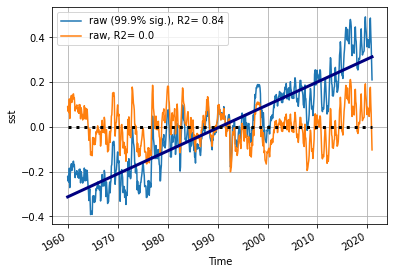

In [25]:
sst_anom.mean(dim=['lon', 'lat']).plot(label='raw')
sst_anom_detrended.mean(dim=['lon', 'lat']).plot(label='detrended')
plt.plot(xtime, i_row + s_row*xts,color='navy',linewidth=3,linestyle='solid')
plt.plot(xtime, i_detrend + s_detrend*xts,color='black',linewidth=3,linestyle="dotted")
plt.grid()

string_row = f"raw (99.9% sig.), R2= {rsq_row}"
string_detrend = f"raw, R2= {rsq_detrend}"

plt.legend([string_row,string_detrend])


The application of Regression map

In [26]:
#read nino3.4 index
ds_oni = xr.open_dataset("/content/drive/My Drive/Colab_data/ENSOindex.oni.1960-2020.nc")
ds_oni = ds_oni.sel(time=slice('1979', '2019'))
#ds_oni['sst'].plot()

#read SST
url = 'http://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/noaa.ersst.v5/sst.mnmean.nc'
ds_sst = xr.open_dataset(url)
ds_sst = ds_sst.sel(time=slice('1979', '2019'))
ds_sst.load()
#ds_sst

#read precipitation
url = 'http://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/gpcp/precip.mon.mean.nc'
ds_prec = xr.open_dataset(url)
ds_prec = ds_prec.sel(time=slice('1979', '2019'))
ds_prec.load()
ds_prec

<xarray.Dataset>
Dimensions:    (lat: 72, lon: 144, nv: 2, time: 492)
Coordinates:
  * lat        (lat) float32 -88.75 -86.25 -83.75 -81.25 ... 83.75 86.25 88.75
  * lon        (lon) float32 1.25 3.75 6.25 8.75 ... 351.2 353.8 356.2 358.8
  * time       (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2019-12-01
Dimensions without coordinates: nv
Data variables:
    time_bnds  (time, nv) datetime64[ns] 1979-01-01 1979-02-01 ... 2020-01-01
    lat_bnds   (lat, nv) float32 -90.0 -87.5 -87.5 -85.0 ... 85.0 87.5 87.5 90.0
    lon_bnds   (lon, nv) float32 0.0 2.5 2.5 5.0 5.0 ... 355.0 357.5 357.5 360.0
    precip     (time, lat, lon) float32 0.0 0.0 0.0 0.0 ... 0.1305 0.1327 0.1341
Attributes: (12/19)
    Conventions:                     CF-1.0
    curator:                         Dr. Jian-Jian Wang\nESSIC, University of...
    citation:                        Adler, R.F., G.J. Huffman, A. Chang, R. ...
    title:                           GPCP Version 2.3 Combined Precipitation ...
    platform:                        NOAA POES (Polar Orbiting Environmental ...
    source_obs:                      CDR RSS SSMI/SSMIS Tbs over ocean \nCDR ...
    ...                              ...
    source_documentation:            https://www.ncdc.noaa.gov/cdr/atmospheri...
    NCO:                             4.6.9
    history:                         Generated at NOAA/ESRL PSD Sep 9 2016 ba...
    References:                      http://www.psl.noaa.gov/data/gridded/dat...
    data_comment:                    Interim data covers 2021/12 through latest.
    DODS_EXTRA.Unlimited_Dimension:  time

In [27]:
ds_climo=ds_prec.groupby('time.month').mean()
ds_anoms=ds_prec.groupby('time.month')-ds_climo
ds_anoms

<xarray.Dataset>
Dimensions:   (lat: 72, lon: 144, nv: 2, time: 492)
Coordinates:
  * lat       (lat) float32 -88.75 -86.25 -83.75 -81.25 ... 83.75 86.25 88.75
  * lon       (lon) float32 1.25 3.75 6.25 8.75 ... 351.2 353.8 356.2 358.8
  * time      (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2019-12-01
    month     (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12
Dimensions without coordinates: nv
Data variables:
    lat_bnds  (time, lat, nv) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    lon_bnds  (time, lon, nv) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    precip    (time, lat, lon) float32 -0.02191 -0.03154 ... -0.2816 -0.2292

In [28]:
nx=len(ds_anoms['lon'])
ny=len(ds_anoms['lat'])

p_array=np.zeros((ny,nx))
r_array=np.zeros((ny,nx))
m_array=np.zeros((ny,nx))

for i in range(nx):
    for j in range(ny):
        
        x=ds_oni['sst']
        y=ds_anoms['precip'][:,j,i]
        
        m,b,r,p,e = linregress(x,y)
        
        m_array[j,i]=m
        r_array[j,i]=r
        p_array[j,i]=p

In [29]:
#mask
mask_sig=np.where(p_array<0.05,m_array,np.nan)

Text(0.5, 1.0, 'Regression between Nino3.4 and Precipitation Anomalies')

/usr/local/lib/python3.7/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naciscdn.org/naturalearth/110m/physical/ne_110m_coastline.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)


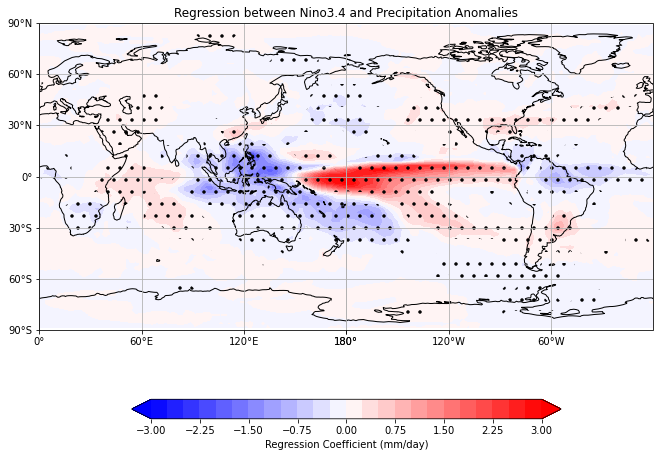

In [30]:
#plotting
clevs=np.arange(-3,3.25,0.25)

fig = plt.figure(figsize=(11,8.5))

# Set the axes using the specified map projection
ax=plt.axes(projection=ccrs.PlateCarree(central_longitude=180))

# Add cyclic point
data=m_array
data,lon=add_cyclic_point(data,coord=ds_anoms['lon'])
mask_data,lons=add_cyclic_point(mask_sig,coord=ds_anoms['lon'])

# Make a filled contour plot
cs=ax.contourf(lon,ds_anoms['lat'],
            data,clevs,
            transform=ccrs.PlateCarree(),
            cmap='bwr',extend='both')

ax.contourf(lon,ds_anoms['lat'],mask_data,[0,1],
            transform = ccrs.PlateCarree(),colors='None',
            hatches=['.','.'],extend='both',alpha=0)

# Add coastlines
ax.coastlines()

# Add gridlines
ax.gridlines()

# Define the xticks for longtitude 
ax.set_xticks(np.arange(-180,181,60),crs=ccrs.PlateCarree())
lon_formatter=cticker.LongitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)

# Define ytick for latitude
ax.set_yticks(np.arange(-90,91,30),crs=ccrs.PlateCarree())
lat_formatter=cticker.LatitudeFormatter()
ax.yaxis.set_major_formatter(lat_formatter)

# Call colorbar
cbar=plt.colorbar(cs,orientation='horizontal',shrink=0.7,
                 label='Regression Coefficient (mm/day)')

# Add title
plt.title('Regression between Nino3.4 and Precipitation Anomalies')